# Querying the Human Lung Cell Atlas

Here we demonstrate how to query the Human Lung Cell Atlas using scANVI and scArches. 

- Sikkema, Lisa, et al. "An integrated cell atlas of the human lung in health and disease." [bioRxiv](https://www.biorxiv.org/content/10.1101/2022.03.10.483747v1) (2022).

If you use this tutorial in your research we recommend citing the HLCA as well as scANVI, scArches, and scvi-tools, which can be found on the [references page](https://docs.scvi-tools.org/en/stable/references.html) at Gayoso22, Lotfollahi21, Xu21 respectively.

This tutorial is adapted from a [similar one](https://github.com/LungCellAtlas/mapping_data_to_the_HLCA/blob/main/notebooks/LCA_scArches_mapping_new_data_to_hlca.ipynb) presented by the HLCA authors.


In [1]:
!pip install --quiet scvi-colab
from scvi_colab import install
install()

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import pynndescent

import anndata
import scanpy as sc
import scvi

sc.set_figure_params(figsize=(4, 4))

# for white background of figures (only for docs rendering)
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
%config InlineBackend.figure_format='retina'

Global seed set to 0


## Download the reference files

First we download the pre-trained scANVI model and the reference cell embedding/metadata from the HCLA Zenodo repository.

In [4]:
%%capture
%%bash
wget https://zenodo.org/record/6337966/files/HLCA_reference_model.zip
unzip HLCA_reference_model.zip
rm HLCA_reference_model.zip

In [5]:
url = "https://zenodo.org/record/6337966/files/HLCA_emb_and_metadata.h5ad"
adata = sc.read("hcla.h5ad", backup_url=url)

  0%|          | 0.00/208M [00:00<?, ?B/s]

In [6]:
adata

AnnData object with n_obs × n_vars = 584884 × 30
    obs: 'sample', 'study_long', 'study', 'last_author_PI', 'subject_ID', 'sex', 'ethnicity', 'mixed_ethnicity', 'smoking_status', 'BMI', 'condition', 'subject_type', 'sample_type', 'single_cell_platform', "3'_or_5'", 'sequencing_platform', 'cell_ranger_version', 'fresh_or_frozen', 'dataset', 'anatomical_region_level_1', 'anatomical_region_level_2', 'anatomical_region_level_3', 'anatomical_region_highest_res', 'age', 'ann_highest_res', 'n_genes', 'log10_total_counts', 'mito_frac', 'ribo_frac', 'original_ann_level_1', 'original_ann_level_2', 'original_ann_level_3', 'original_ann_level_4', 'original_ann_level_5', 'scanvi_label', 'leiden_1', 'leiden_2', 'leiden_3', 'anatomical_region_ccf_score', 'entropy_study_leiden_3', 'entropy_dataset_leiden_3', 'entropy_subject_ID_leiden_3', 'entropy_original_ann_level_1_leiden_3', 'entropy_original_ann_level_2_clean_leiden_3', 'entropy_original_ann_level_3_clean_leiden_3', 'entropy_original_ann_level_4

## Learn a neighbors index on reference latent space

Here we create the neighbors index using `PyNNDescent`. We will use this later to classify query cells. `PyNNDescent` is an extremely fast approximate neighbors technique.

In [7]:
X_train = adata.X
ref_nn_index = pynndescent.NNDescent(X_train)
ref_nn_index.prepare()

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


## Download query data

In this tutorial we use the fresh, single-cell sample from the following publication:

- Delorey, Toni M., et al. "COVID-19 tissue atlases reveal SARS-CoV-2 pathology and cellular targets." Nature 595.7865 (2021): 107-113.

In principle at this stage you may load your own data. There are few important notes though:

- Using the HLCA requires using Gene IDs for the query data
- The query data should include batches in `query_data.obs["dataset"]`
- It's necessary to run `query_data.obs["scanvi_label"] = "unlabeled"` so that scvi-tools can properly register the query data.

In [8]:
%%capture
%%bash
wget https://ftp.ncbi.nlm.nih.gov/geo/samples/GSM5230nnn/GSM5230027/suppl/GSM5230027_04-P103142-S149-R01_raw_feature_bc_matrix.h5.gz -O query_test.h5.gz
gzip -d query_test.h5.gz

In [9]:
geo_metadata_url = "https://ftp.ncbi.nlm.nih.gov/geo/series/GSE171nnn/GSE171668/suppl/GSE171668_lung_metadata.csv.gz"
metadata = pd.read_csv(geo_metadata_url, index_col=0)
query_data = sc.read_10x_h5("query_test.h5")
# clean up .var.index (gene names)
query_data.var['gene_names'] = query_data.var.index
query_data.var.index = [idx.split("___")[-1] for idx in query_data.var.gene_ids]
# clean up cell barcodes:
query_data.obs.index = query_data.obs.index.str.rstrip("-1")
# read in metadata (to select only cells of interest and remove empty drops)
# subset to cells from our sample
metadata = metadata.loc[metadata.donor == "D12_4",:].copy()
# clean up barcodes:
metadata.index = [idx.split("-")[-1] for idx in metadata.index]
# subset adata to cells in metadata:
query_data = query_data[metadata.index,:].copy()
# add dataset information:
query_data.obs['dataset'] = "test_dataset_delorey_regev"

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


## Loading the query model from the reference files

Here we run `prepare_query_anndata`, which reorders the genes and pads any missing genes with 0s. This should generally be run before reference mapping with scArches to ensure data correctness.

In [10]:
ref_model_path = "HLCA_reference_model"
scvi.model.SCANVI.prepare_query_anndata(query_data, ref_model_path)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function _load_legacy_saved_files is deprecated; Please update your saved models to use the latest version. The legacy save and load scheme will be removed in version 0.16.0.
  warnings.warn(msg, category=FutureWarning)


INFO     Found 99.65% reference vars in query data.                                          


In [11]:
query_data.obs["scanvi_label"] = "unlabeled"

In [12]:
query_model = scvi.model.SCANVI.load_query_data(query_data, ref_model_path)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function _load_legacy_saved_files is deprecated; Please update your saved models to use the latest version. The legacy save and load scheme will be removed in version 0.16.0.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/scvi/model/_scanvi.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  labels == self.unlabeled_category_
/usr/local/lib/python3.7/dist-packages/scvi/model/_scanvi.py:255: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  self._labeled_indices = np.argwhere(labels != self.unlabeled_category_).ravel()


Here we use scArches/scANVI-specific query training arguments.

In [13]:
surgery_epochs = 500
train_kwargs_surgery = {
    "early_stopping": True,
    "early_stopping_monitor": "elbo_train",
    "early_stopping_patience": 10,
    "early_stopping_min_delta": 0.001,
    "plan_kwargs": {"weight_decay": 0.0},
}

In [14]:
query_model.train(
    max_epochs=surgery_epochs,
    **train_kwargs_surgery
)

INFO     Training for 500 epochs.                                                            


INFO:scvi.model._scanvi:Training for 500 epochs.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 285/500:  57%|█████▋    | 285/500 [01:37<01:13,  2.91it/s, loss=497, v_num=1]
Monitored metric elbo_train did not improve in the last 10 records. Best score: 524.872. Signaling Trainer to stop.


In [15]:
query_save_path = "hcla_query/"
query_model.save(query_save_path, overwrite=True)

In [16]:
query_emb = sc.AnnData(query_model.get_latent_representation())
query_emb.obs_names = query_data.obs_names

Now let's store the predictions in the query embedding object. We reuse the PyNNDescent index from before, converting distances to affinities, and weighting the predictions using these affinities.

This follows the same approach used in the HLCA.

In [17]:
import numba
ref_neighbors, ref_distances = ref_nn_index.query(query_emb.X)

# convert distances to affinities
stds = np.std(ref_distances, axis=1)
stds = (2.0 / stds) ** 2
stds = stds.reshape(-1, 1)
ref_distances_tilda = np.exp(-np.true_divide(ref_distances, stds))
weights = ref_distances_tilda / np.sum(
    ref_distances_tilda, axis=1, keepdims=True
)

@numba.njit
def weighted_prediction(weights, ref_cats):
    """Get highest weight category."""
    N = len(weights)
    predictions = np.zeros((N,), dtype=ref_cats.dtype)
    uncertainty = np.zeros((N,))
    for i in range(N):
        obs_weights = weights[i]
        obs_cats = ref_cats[i]
        best_prob = 0
        for c in np.unique(obs_cats):
            cand_prob = np.sum(obs_weights[obs_cats == c])
            if cand_prob > best_prob:
                best_prob = cand_prob
                predictions[i] = c
                uncertainty[i] = max(1 - best_prob, 0)

    return predictions, uncertainty

# for each annotation level, get prediction and uncertainty
label_keys = [f"ann_level_{i}" for i in range(1, 6)] + ["ann_finest_level"]
for l in label_keys:
    ref_cats = adata.obs[l].cat.codes.to_numpy()[ref_neighbors]
    p, u = weighted_prediction(weights, ref_cats)
    p = np.asarray(adata.obs[l].cat.categories)[p]
    query_emb.obs[l + "_pred"], query_emb.obs[l + "_uncertainty"] = p, u


Now let's filter our predictions on the uncertainty threshold, which is discussed in the HLCA manuscript.

In [18]:
uncertainty_threshold = 0.2
for l in label_keys:
    mask = query_emb.obs[l + "_uncertainty"] > 0.2
    print(f"{l}: {sum(mask)/len(mask)} unknown")
    query_emb.obs[l + "_pred"].loc[mask] = "Unknown"

ann_level_1: 0.003919372900335946 unknown
ann_level_2: 0.0083986562150056 unknown
ann_level_3: 0.0755879059350504 unknown
ann_level_4: 0.3986562150055991 unknown
ann_level_5: 0.0083986562150056 unknown
ann_finest_level: 0.41825307950727886 unknown


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [19]:
query_emb.obs["dataset"] = "test_dataset_delorey_regev"

## Combine embeddings

In [20]:
adata

AnnData object with n_obs × n_vars = 584884 × 30
    obs: 'sample', 'study_long', 'study', 'last_author_PI', 'subject_ID', 'sex', 'ethnicity', 'mixed_ethnicity', 'smoking_status', 'BMI', 'condition', 'subject_type', 'sample_type', 'single_cell_platform', "3'_or_5'", 'sequencing_platform', 'cell_ranger_version', 'fresh_or_frozen', 'dataset', 'anatomical_region_level_1', 'anatomical_region_level_2', 'anatomical_region_level_3', 'anatomical_region_highest_res', 'age', 'ann_highest_res', 'n_genes', 'log10_total_counts', 'mito_frac', 'ribo_frac', 'original_ann_level_1', 'original_ann_level_2', 'original_ann_level_3', 'original_ann_level_4', 'original_ann_level_5', 'scanvi_label', 'leiden_1', 'leiden_2', 'leiden_3', 'anatomical_region_ccf_score', 'entropy_study_leiden_3', 'entropy_dataset_leiden_3', 'entropy_subject_ID_leiden_3', 'entropy_original_ann_level_1_leiden_3', 'entropy_original_ann_level_2_clean_leiden_3', 'entropy_original_ann_level_3_clean_leiden_3', 'entropy_original_ann_level_4

In [21]:
query_emb

AnnData object with n_obs × n_vars = 1786 × 30
    obs: 'ann_level_1_pred', 'ann_level_1_uncertainty', 'ann_level_2_pred', 'ann_level_2_uncertainty', 'ann_level_3_pred', 'ann_level_3_uncertainty', 'ann_level_4_pred', 'ann_level_4_uncertainty', 'ann_level_5_pred', 'ann_level_5_uncertainty', 'ann_finest_level_pred', 'ann_finest_level_uncertainty', 'dataset'

In [22]:
combined_emb = adata.concatenate(query_emb)

## Visualize embeddings and predictions

To visualize here we use [minimum distortion embeddings](https://pymde.org/), which for now can be thought of as an alternative of UMAP that is GPU-accelerated (= really fast on Colab). While we use `init="random"` here, we recommend removing this argument in practice and only leave it here to make the notebook run faster.

In [23]:
from scvi.model.utils import mde

combined_emb.obsm["X_mde"] = mde(combined_emb.X, init="random")

/usr/local/lib/python3.7/dist-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'dataset' as categorical
/usr/local/lib/python3.7/dist-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'ann_level_1_pred' as categorical
/usr/local/lib/python3.7/dist-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a n

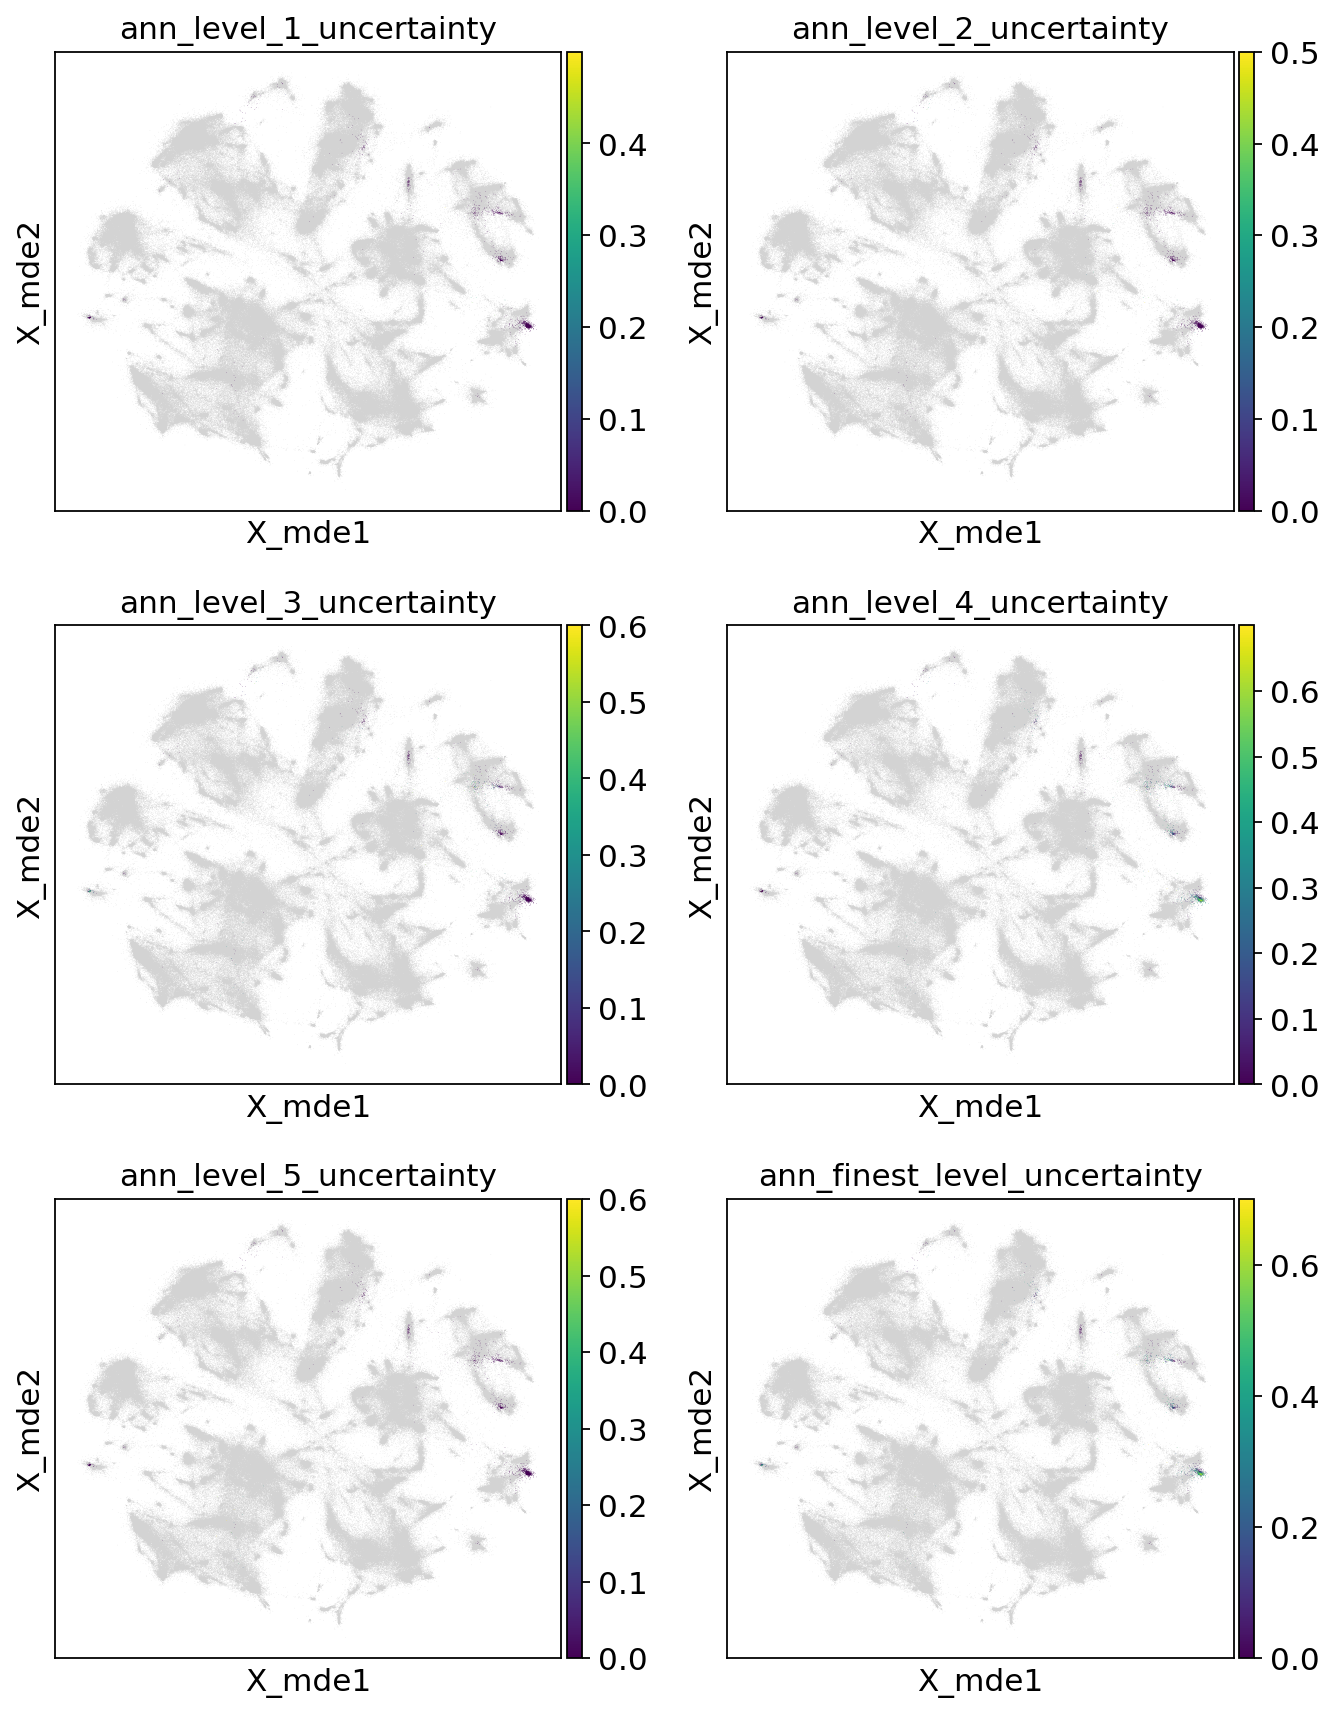

In [24]:
colors = [l + "_uncertainty" for l in label_keys]
sc.pl.embedding(
    combined_emb, 
    basis="X_mde", 
    color=colors, 
    ncols=2, 
)

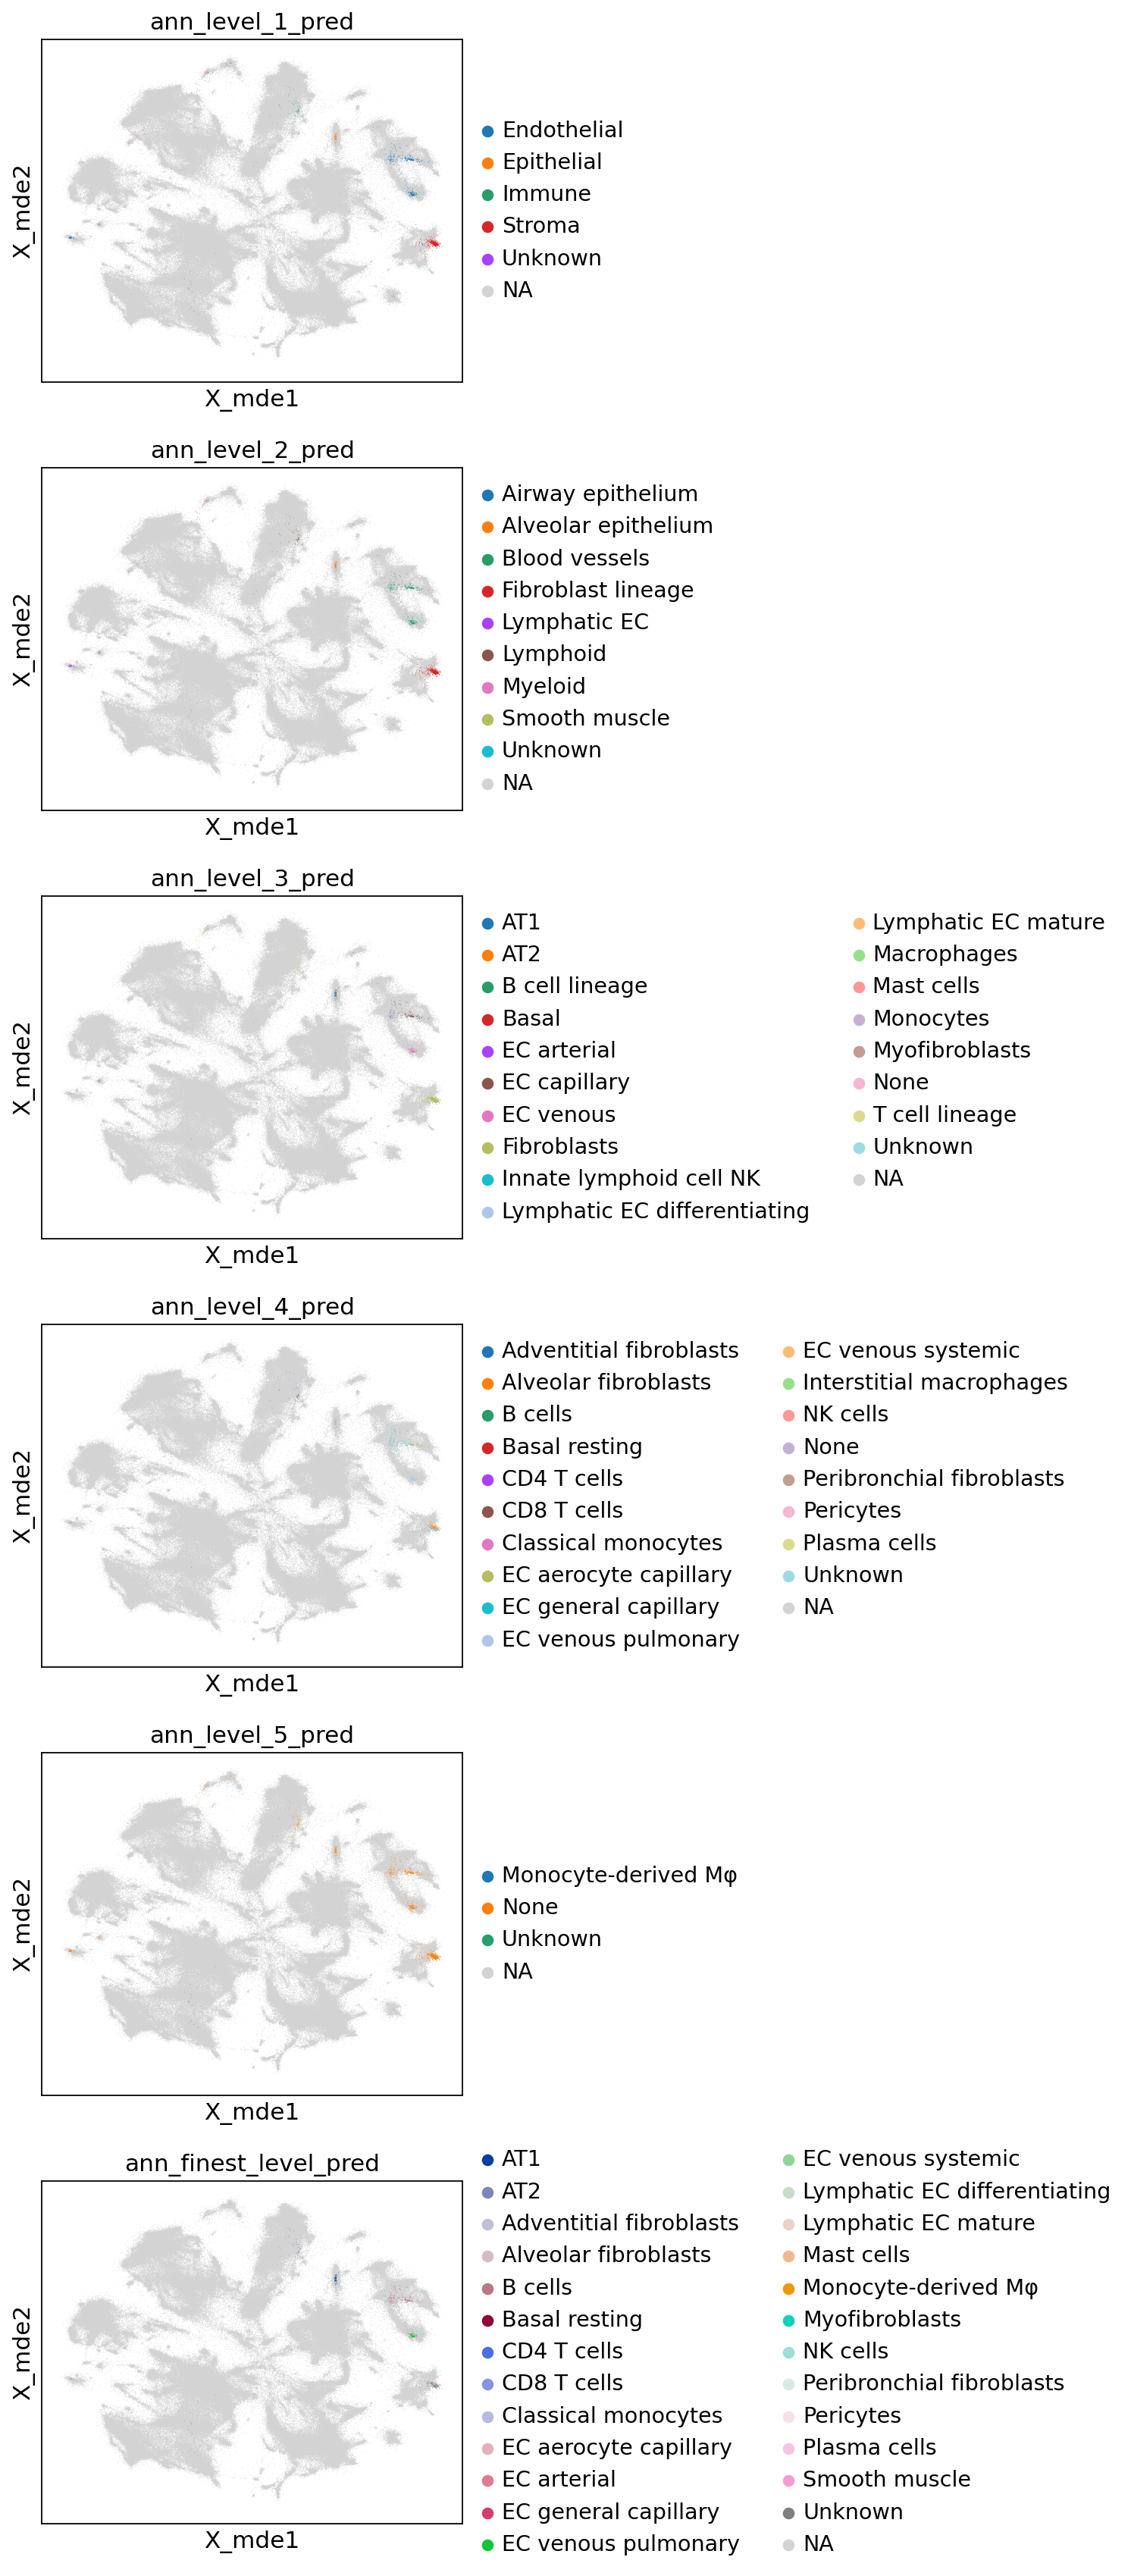

In [25]:
colors = [l + "_pred" for l in label_keys]

sc.pl.embedding(combined_emb, basis="X_mde", color=colors, ncols=1, size=0.5)


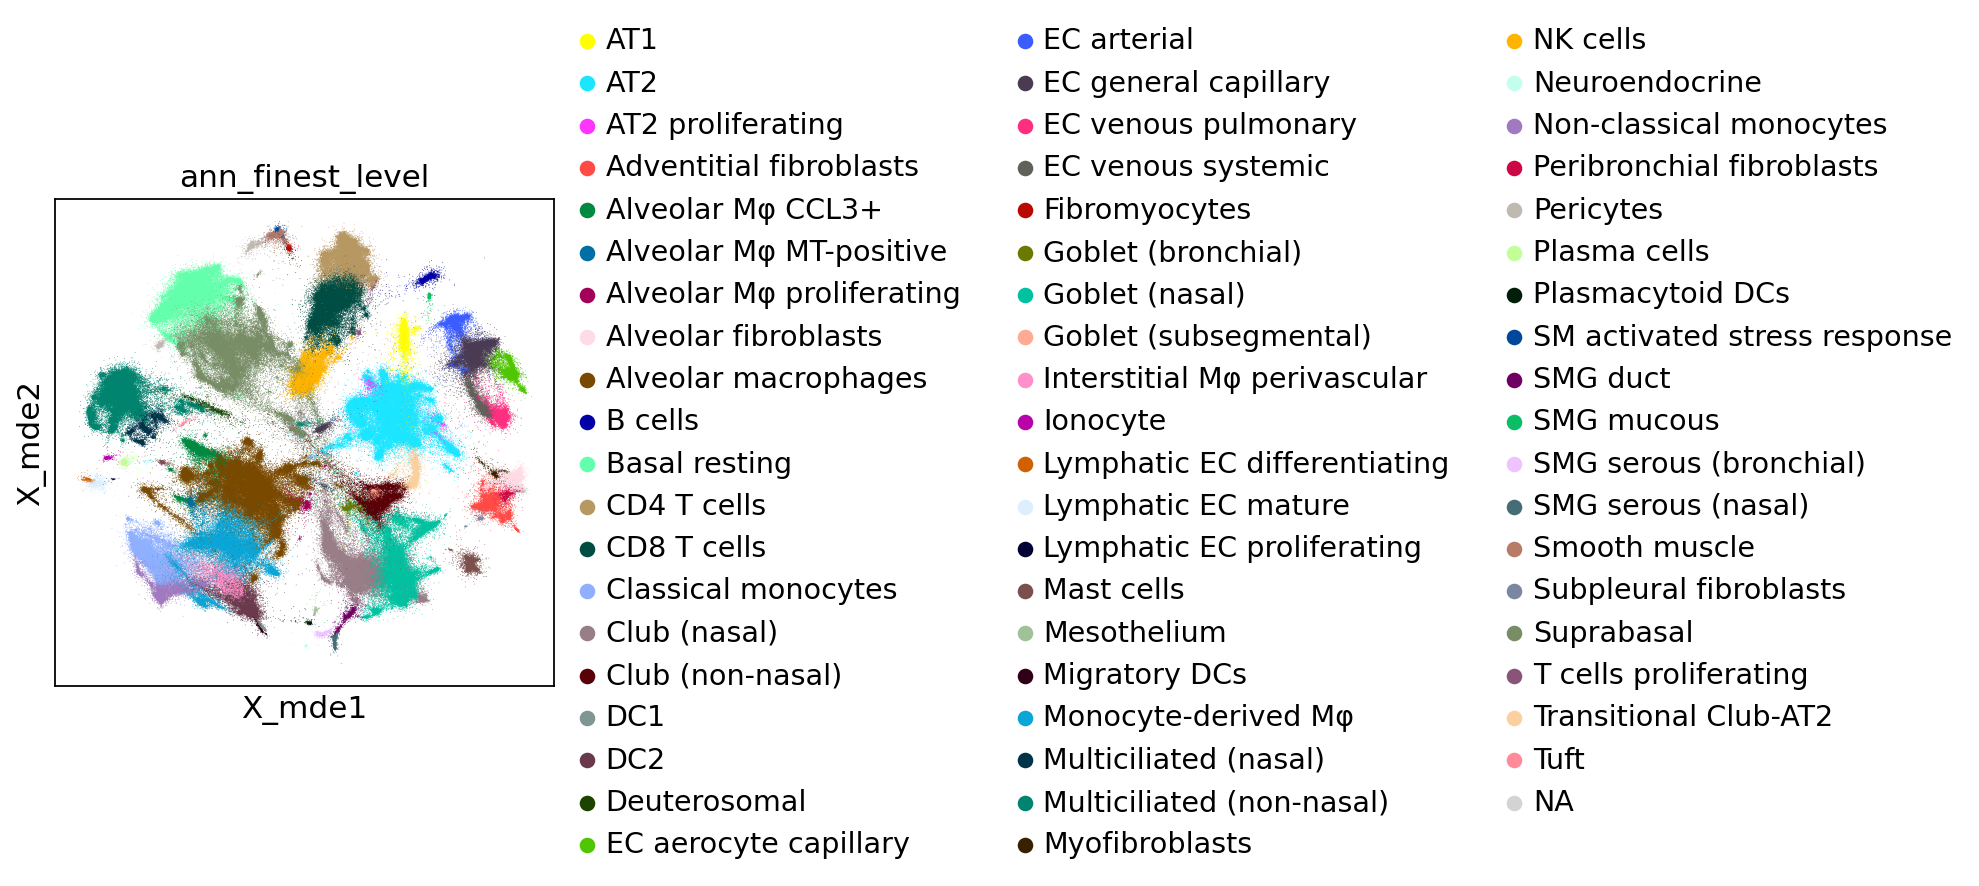

In [26]:
sc.pl.embedding(combined_emb, basis="X_mde", color="ann_finest_level", ncols=1, size=0.5)
